# Imports

In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling
import pickle
from torch_geometric.nn import VGAE, GATv2Conv
from sklearn.model_selection import KFold
from torch.nn import Linear, Sequential, ReLU
from torch.utils.tensorboard import SummaryWriter

# Step 1 -> Load Dataset

In [2]:
df = pd.read_csv('new_chembl_inhibit_drug_target.csv')  # Replace with your CSV path
df = df[['compound_chembl_id', 'target_accession_number']]
df.drop_duplicates(inplace=True)

# Step 2 -> Construct the graph

In [3]:
# Set up the device (use CUDA if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Initialize HeteroData object
data = HeteroData()

# Add compound nodes
compounds = df['compound_chembl_id'].unique()
compound_map = {compound: i for i, compound in enumerate(compounds)}

# Add target nodes
targets = df['target_accession_number'].unique()
target_map = {target: i for i, target in enumerate(targets)}

# Add edges (compound <-> target) ensuring undirected edges
compound_indices = np.array(df['compound_chembl_id'].map(compound_map).values)
target_indices = np.array(df['target_accession_number'].map(target_map).values)

# Convert to PyTorch tensors and move to GPU
edge_index = torch.tensor(np.vstack([target_indices, compound_indices]), dtype=torch.long).to(device)

data['protein', 'interacts', 'drug'].edge_index = edge_index

# Load PPI data
cancer_ppi_data = pd.read_csv('cancer_ppi_combined.csv')

# Add Protein Nodes
existing_proteins = set(target_map.keys())

# Filter only valid PPI interactions
cancer_ppi_data_filtered = cancer_ppi_data[
    (cancer_ppi_data['node1_uniprot_id'].isin(existing_proteins)) | 
    (cancer_ppi_data['node2_uniprot_id'].isin(existing_proteins))
]

# Map PPI edges to indices
ppi_edges = []
len_target_map = len(target_map)

for _, row in cancer_ppi_data_filtered.iterrows():
    node1, node2 = row['node1_uniprot_id'], row['node2_uniprot_id']
    
    # Assign indices if not already mapped
    if node1 not in target_map:
        target_map[node1] = len_target_map
        len_target_map += 1
    if node2 not in target_map:
        target_map[node2] = len_target_map
        len_target_map += 1

    # Append undirected edges
    ppi_edges.append([target_map[node1], target_map[node2]])
    ppi_edges.append([target_map[node2], target_map[node1]])  # Add reverse edge

# Convert PPI edges to tensor
ppi_edge_index = torch.tensor(ppi_edges, dtype=torch.long).T.to(device)

# Assign undirected PPI edges to the graph
data['protein', 'interacts', 'protein'].edge_index = ppi_edge_index

data['drug'].x = torch.load('compound_features.pt')

embeddings_dict_merged = pickle.load(open("embeddings_dict.pkl", "rb"))

# Add protein features
target_features = []

# Load target features in order of the target_map value (index)
for idx in range(len(target_map)):
    protein = [protein for protein, i in target_map.items() if i == idx][0]
    if protein in embeddings_dict_merged:
        target_features.append(embeddings_dict_merged[protein])
    else:
        target_features.append(np.zeros(1024))

data['protein'].x = torch.tensor(target_features, dtype=torch.float).to(device)

C:\Users\chakr\AppData\Local\Temp\ipykernel_30300\1068464817.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  data['protein'].x = torch.tensor(target_features, dtype=torch.float).to(device)


In [4]:
# Reconstruct targets from the target_map
targets = [protein for protein, _ in sorted(target_map.items(), key=lambda x: x[1])]

In [5]:
# Reconstruct drugs from the compound_map
drugs = [drug for drug, _ in sorted(compound_map.items(), key=lambda x: x[1])]

In [6]:
# Check the new feature shapes
print("Compound node features shape", data['drug'].x.shape)
print("Target node features shape", data['protein'].x.shape)

# Check shapes to verify
print("Edge index shape:", data['protein', 'interacts', 'drug'].edge_index.shape)
print("PPI edge index shape:", data['protein', 'interacts', 'protein'].edge_index.shape)

Compound node features shape torch.Size([46660, 1024])
Target node features shape torch.Size([4683, 1024])
Edge index shape: torch.Size([2, 83888])
PPI edge index shape: torch.Size([2, 53908])


In [7]:
print(data)

HeteroData(
  drug={ x=[46660, 1024] },
  protein={ x=[4683, 1024] },
  (protein, interacts, drug)={ edge_index=[2, 83888] },
  (protein, interacts, protein)={ edge_index=[2, 53908] }
)


In [8]:
def make_undirected(data, edge_types):
    for src, rel, dst in edge_types:
        if src != dst:  # Only add reverse edges for heterogeneous edges
            reverse_edges = torch.flip(data[src, rel, dst].edge_index, [0])
            data[dst, rel, src].edge_index = reverse_edges
        else:  # For self-looping edges (protein, interacts, protein)
            data[src, rel, dst].edge_index = torch.cat([
                data[src, rel, dst].edge_index, torch.flip(data[src, rel, dst].edge_index, [0])
            ], dim=1)
    return data

data = make_undirected(data, [('protein', 'interacts', 'drug'), ('protein', 'interacts', 'protein')])

In [9]:
print(data)

HeteroData(
  drug={ x=[46660, 1024] },
  protein={ x=[4683, 1024] },
  (protein, interacts, drug)={ edge_index=[2, 83888] },
  (protein, interacts, protein)={ edge_index=[2, 107816] },
  (drug, interacts, protein)={ edge_index=[2, 83888] }
)


In [10]:
splitter = RandomLinkSplit(
    num_val=0.1,  # 10% validation
    num_test=0.2,  # 20% test
    is_undirected=True,  # Since we made the graph undirected
    edge_types=('protein', 'interacts', 'drug'),  # Apply to protein-drug interactions
    rev_edge_types=('drug', 'interacts', 'protein'),  # Reverse edge type
)

train_data, val_data, test_data = splitter(data)

# Move split datasets to the same device
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [11]:
print(train_data)

HeteroData(
  drug={ x=[46660, 1024] },
  protein={ x=[4683, 1024] },
  (protein, interacts, drug)={
    edge_index=[2, 58723],
    edge_label=[117446],
    edge_label_index=[2, 117446],
  },
  (protein, interacts, protein)={ edge_index=[2, 107816] },
  (drug, interacts, protein)={ edge_index=[2, 58723] }
)


# Variational Graph Autoencoder

# GAT based VAE

In [12]:
# **GAT-based Variational Encoder**
class GATv2Encoder(torch.nn.Module):
    def __init__(self, metadata, in_channels, hidden_dim, out_channels, heads=2):
        super().__init__()
        self.metadata = metadata  # Store graph metadata

        # Define GAT layers for each node type
        self.conv1 = torch.nn.ModuleDict({
            str(edge_type): GATv2Conv(in_channels, hidden_dim, heads=heads, concat=True, add_self_loops=False)
            for edge_type in metadata[1]  # Edge types
        })

        self.conv2 = torch.nn.ModuleDict({
            str(edge_type): GATv2Conv(hidden_dim * heads, out_channels, heads=1, concat=False, add_self_loops=False)
            for edge_type in metadata[1]  # Edge types
        })

        self.mu = torch.nn.ModuleDict({
            node_type: Linear(out_channels, out_channels)
            for node_type in metadata[0]
        })

        self.logstd = torch.nn.ModuleDict({
            node_type: Linear(out_channels, out_channels)
            for node_type in metadata[0]
        })

    def forward(self, x_dict, edge_index_dict):
        updated = {nt: [] for nt in self.metadata[0]}
        attn_scores = {edge_type: None for edge_type in edge_index_dict.keys()}  # Store attention scores

        # First layer: update destination nodes for each edge type
        for edge_type, edge_index in edge_index_dict.items():
            src, _, dst = edge_type
            x_out = self.conv1[str(edge_type)]((x_dict[src], x_dict[dst]), edge_index)
            x_out = F.relu(x_out)
            updated[dst].append(x_out)

        # Aggregate updates (e.g., via mean) for each node type
        x_updated = {}
        for nt in updated:
            if updated[nt]:
                x_updated[nt] = torch.mean(torch.stack(updated[nt]), dim=0)
            else:
                # If no update was computed (node never appeared as destination), fall back to raw features
                x_updated[nt] = x_dict[nt]

        # Second layer: now both source and destination have updated features
        z_dict = {}
        for edge_type, edge_index in edge_index_dict.items():
            src, _, dst = edge_type
            # Use updated features for both roles now
            x_out, (edge_index_, attn) = self.conv2[str(edge_type)]((x_updated[src], x_updated[dst]), edge_index, return_attention_weights=True)
            attn_scores[edge_type] = (edge_index_, attn) # Store attention scores
            if dst not in z_dict:
                z_dict[dst] = x_out
            else:
                z_dict[dst] = torch.mean(torch.stack([z_dict[dst], x_out]), dim=0)
        return {nt: self.mu[nt](z) for nt, z in z_dict.items()}, {nt: self.logstd[nt](z) for nt, z in z_dict.items()}, attn_scores

# **MLP-based Decoder**
class MLPDecoder(torch.nn.Module):
    def __init__(self, out_channels, hidden_dim):
        super().__init__()
        self.mlp = Sequential(
            Linear(2 * out_channels, hidden_dim),
            ReLU(),
            Linear(hidden_dim, 1)  # Output: probability of link
        )

    def forward(self, z_dict, edge_index, src, dst):
        src_e, dst_e = edge_index
        z_src = z_dict[src][src_e]
        z_dst = z_dict[dst][dst_e]

        z = torch.cat([z_src, z_dst], dim=-1)  # Batch process all edges
        edge_probs = self.mlp(z)  # Process in a single forward pass

        edge_probs = torch.sigmoid(edge_probs)  # Sigmoid activation

        return edge_probs.view(-1)  # Reshape to 1D tensor

# **VGAE Model with GATv2 Encoder & MLP Decoder**
class GATVGAE(VGAE):
    def __init__(self, metadata, in_channels, hidden_dim, out_channels, decoder_hidden_dim, heads=2):
        encoder = GATv2Encoder(metadata, in_channels, hidden_dim, out_channels, heads)
        super().__init__(encoder)
        self.decoder = MLPDecoder(out_channels, decoder_hidden_dim)

    def encode(self, x_dict, edge_index_dict):
        mu_dict, logstd_dict, attn_scores = self.encoder(x_dict, edge_index_dict)

        # Compute latent embeddings for each node type
        self.__mu__ = {nt: mu for nt, mu in mu_dict.items()}
        self.__logstd__ = {nt: logstd.clamp(max=10) for nt, logstd in logstd_dict.items()}  # Clamp logstd

        # Reparametrize
        z_dict = {nt: self.reparametrize(mu, logstd) for nt, (mu, logstd) in zip(mu_dict.keys(), zip(mu_dict.values(), self.__logstd__.values()))}
        return z_dict, mu_dict, logstd_dict, attn_scores

    def decode(self, z_dict, edge_index, src, dst, decode_dot=False):
        if decode_dot:
            src_e, dst_e = edge_index
            z_src = z_dict[src][src_e]
            z_dst = z_dict[dst][dst_e]
            edge_probs = torch.sigmoid(torch.sum(z_src * z_dst, dim=-1))
            return edge_probs.view(-1)
        else:
            return self.decoder(z_dict, edge_index, src, dst)


# GraphSAGE based VGAE

In [13]:
from torch_geometric.nn import SAGEConv

class SAGEEncoder(torch.nn.Module):
    def __init__(self, metadata, in_channels, hidden_dim, out_channels):
        super().__init__()
        self.metadata = metadata

        self.conv1 = torch.nn.ModuleDict({
            str(edge_type): SAGEConv(in_channels, hidden_dim)
            for edge_type in metadata[1]
        })

        self.conv2 = torch.nn.ModuleDict({
            str(edge_type): SAGEConv(hidden_dim, out_channels)
            for edge_type in metadata[1]
        })

        self.mu = torch.nn.ModuleDict({
            node_type: Linear(out_channels, out_channels)
            for node_type in metadata[0]
        })

        self.logstd = torch.nn.ModuleDict({
            node_type: Linear(out_channels, out_channels)
            for node_type in metadata[0]
        })

    def forward(self, x_dict, edge_index_dict):
        updated = {nt: [] for nt in self.metadata[0]}

        for edge_type, edge_index in edge_index_dict.items():
            src, _, dst = edge_type
            x = self.conv1[str(edge_type)]((x_dict[src], x_dict[dst]), edge_index)
            x = F.relu(x)
            updated[dst].append(x)

        x_updated = {
            nt: torch.mean(torch.stack(updated[nt]), dim=0) if updated[nt] else x_dict[nt]
            for nt in updated
        }

        z_dict = {}
        for edge_type, edge_index in edge_index_dict.items():
            src, _, dst = edge_type
            x = self.conv2[str(edge_type)]((x_updated[src], x_updated[dst]), edge_index)
            if dst not in z_dict:
                z_dict[dst] = x
            else:
                z_dict[dst] = torch.mean(torch.stack([z_dict[dst], x]), dim=0)

        return {nt: self.mu[nt](z) for nt, z in z_dict.items()}, {nt: self.logstd[nt](z) for nt, z in z_dict.items()}, None

class SAGEVGAE(VGAE):
    def __init__(self, metadata, in_channels, hidden_dim, out_channels, decoder_hidden_dim, heads=None):
        encoder = SAGEEncoder(metadata, in_channels, hidden_dim, out_channels)
        super().__init__(encoder)
        self.decoder = MLPDecoder(out_channels, decoder_hidden_dim)

    def encode(self, x_dict, edge_index_dict):
        mu_dict, logstd_dict, _ = self.encoder(x_dict, edge_index_dict)
        self.__mu__ = mu_dict
        self.__logstd__ = {nt: logstd.clamp(max=10) for nt, logstd in logstd_dict.items()}
        z_dict = {nt: self.reparametrize(mu, logstd) for nt, (mu, logstd) in zip(mu_dict.keys(), zip(mu_dict.values(), self.__logstd__.values()))}
        return z_dict, mu_dict, logstd_dict, None

    def decode(self, z_dict, edge_index, src, dst, decode_dot=False):
        if decode_dot:
            src_e, dst_e = edge_index
            z_src = z_dict[src][src_e]
            z_dst = z_dict[dst][dst_e]
            edge_probs = torch.sigmoid(torch.sum(z_src * z_dst, dim=-1))
            return edge_probs.view(-1)
        else:
            return self.decoder(z_dict, edge_index, src, dst)


# GraphConv based VGAE

In [14]:
from torch_geometric.nn import GraphConv

class GraphConvEncoder(torch.nn.Module):
    def __init__(self, metadata, in_channels, hidden_dim, out_channels):
        super().__init__()
        self.metadata = metadata

        self.conv1 = torch.nn.ModuleDict({
            str(edge_type): GraphConv(in_channels, hidden_dim)
            for edge_type in metadata[1]
        })

        self.conv2 = torch.nn.ModuleDict({
            str(edge_type): GraphConv(hidden_dim, out_channels)
            for edge_type in metadata[1]
        })

        self.mu = torch.nn.ModuleDict({
            node_type: Linear(out_channels, out_channels)
            for node_type in metadata[0]
        })

        self.logstd = torch.nn.ModuleDict({
            node_type: Linear(out_channels, out_channels)
            for node_type in metadata[0]
        })

    def forward(self, x_dict, edge_index_dict):
        updated = {nt: [] for nt in self.metadata[0]}
        for edge_type, edge_index in edge_index_dict.items():
            src, _, dst = edge_type
            x = self.conv1[str(edge_type)]((x_dict[src], x_dict[dst]), edge_index)
            x = F.relu(x)
            updated[dst].append(x)

        x_updated = {
            nt: torch.mean(torch.stack(updated[nt]), dim=0) if updated[nt] else x_dict[nt]
            for nt in updated
        }

        z_dict = {}
        for edge_type, edge_index in edge_index_dict.items():
            src, _, dst = edge_type
            x = self.conv2[str(edge_type)]((x_updated[src], x_updated[dst]), edge_index)
            if dst not in z_dict:
                z_dict[dst] = x
            else:
                z_dict[dst] = torch.mean(torch.stack([z_dict[dst], x]), dim=0)

        return {nt: self.mu[nt](z) for nt, z in z_dict.items()}, {nt: self.logstd[nt](z) for nt, z in z_dict.items()}, None

class GraphConvVGAE(VGAE):
    def __init__(self, metadata, in_channels, hidden_dim, out_channels, decoder_hidden_dim ,heads=None):
        encoder = GraphConvEncoder(metadata, in_channels, hidden_dim, out_channels)
        super().__init__(encoder)
        self.decoder = MLPDecoder(out_channels, decoder_hidden_dim)

    def encode(self, x_dict, edge_index_dict):
        mu_dict, logstd_dict, _ = self.encoder(x_dict, edge_index_dict)
        self.__mu__ = mu_dict
        self.__logstd__ = {nt: logstd.clamp(max=10) for nt, logstd in logstd_dict.items()}
        z_dict = {nt: self.reparametrize(mu, logstd) for nt, (mu, logstd) in zip(mu_dict.keys(), zip(mu_dict.values(), self.__logstd__.values()))}
        return z_dict, mu_dict, logstd_dict, None

    def decode(self, z_dict, edge_index, src, dst, decode_dot=False):
        if decode_dot:
            src_e, dst_e = edge_index
            z_src = z_dict[src][src_e]
            z_dst = z_dict[dst][dst_e]
            return torch.sigmoid(torch.sum(z_src * z_dst, dim=-1)).view(-1)
        else:
            return self.decoder(z_dict, edge_index, src, dst)


# Transformer based VGAE

In [15]:
from torch_geometric.nn import TransformerConv

class TransformerEncoder(torch.nn.Module):
    def __init__(self, metadata, in_channels, hidden_dim, out_channels, heads=4, dropout=0.2):
        super().__init__()
        self.metadata = metadata

        self.conv1 = torch.nn.ModuleDict({
            str(edge_type): TransformerConv(in_channels, hidden_dim, heads=heads ,concat=True, beta=True, dropout=dropout)
            for edge_type in metadata[1]
        })

        self.conv2 = torch.nn.ModuleDict({
            str(edge_type): TransformerConv(hidden_dim * heads, out_channels, heads=1, concat=False, beta=True, dropout=dropout/2)
            for edge_type in metadata[1]
        })

        self.mu = torch.nn.ModuleDict({
            node_type: Linear(out_channels, out_channels)
            for node_type in metadata[0]
        })

        self.logstd = torch.nn.ModuleDict({
            node_type: Linear(out_channels, out_channels)
            for node_type in metadata[0]
        })

    def forward(self, x_dict, edge_index_dict):
        updated = {nt: [] for nt in self.metadata[0]}
        attn_scores = {edge_type: None for edge_type in edge_index_dict.keys()}  # Store attention scores

        for edge_type, edge_index in edge_index_dict.items():
            src, _, dst = edge_type
            x = self.conv1[str(edge_type)]((x_dict[src], x_dict[dst]), edge_index)
            x = F.relu(x)
            updated[dst].append(x)

        x_updated = {
            nt: torch.mean(torch.stack(updated[nt]), dim=0) if updated[nt] else x_dict[nt]
            for nt in updated
        }

        z_dict = {}
        for edge_type, edge_index in edge_index_dict.items():
            src, _, dst = edge_type
            x, (edge_index_, attn) = self.conv2[str(edge_type)]((x_updated[src], x_updated[dst]), edge_index, return_attention_weights=True)
            attn_scores[edge_type] = (edge_index_, attn) # Store attention scores
            if dst not in z_dict:
                z_dict[dst] = x
            else:
                z_dict[dst] = torch.mean(torch.stack([z_dict[dst], x]), dim=0)

        return {nt: self.mu[nt](z) for nt, z in z_dict.items()}, {nt: self.logstd[nt](z) for nt, z in z_dict.items()}, attn_scores

class TransformerVGAE(VGAE):
    def __init__(self, metadata, in_channels, hidden_dim, out_channels, decoder_hidden_dim, heads=4, dropout=0.2):
        encoder = TransformerEncoder(metadata, in_channels, hidden_dim, out_channels, heads=heads, dropout=dropout)
        super().__init__(encoder)
        self.decoder = MLPDecoder(out_channels, decoder_hidden_dim)

    def encode(self, x_dict, edge_index_dict):
        mu_dict, logstd_dict, attn_scores = self.encoder(x_dict, edge_index_dict)
        self.__mu__ = mu_dict
        self.__logstd__ = {nt: logstd.clamp(max=10) for nt, logstd in logstd_dict.items()}
        z_dict = {nt: self.reparametrize(mu, logstd) for nt, (mu, logstd) in zip(mu_dict.keys(), zip(mu_dict.values(), self.__logstd__.values()))}
        return z_dict, mu_dict, logstd_dict, attn_scores

    def decode(self, z_dict, edge_index, src, dst, decode_dot=False):
        if decode_dot:
            src_e, dst_e = edge_index
            z_src = z_dict[src][src_e]
            z_dst = z_dict[dst][dst_e]
            return torch.sigmoid(torch.sum(z_src * z_dst, dim=-1)).view(-1)
        else:
            return self.decoder(z_dict, edge_index, src, dst)


In [16]:
in_channels = 1024  # Assuming node features have 1024 dimensions
hidden_dim = 128
out_channels = 128
decoder_hidden_dim = 128
heads = 8

model = GATVGAE(data.metadata(), in_channels, hidden_dim, out_channels, decoder_hidden_dim, heads).to(device)

In [17]:
data = data.to(device)
model = model.to(device)

In [18]:
def train(model, data, optimizer, device, beta = 1, simple_decode=False):
    model.train()
    optimizer.zero_grad()
    
    # Encode graph (get mean & log-variance of latent distribution)
    z_dict, mu_dict, logstd_dict, _ = model.encode(data.x_dict, data.edge_index_dict)

    # Compute KL loss (only for protein and drug nodes)
    kl_loss = sum(model.kl_loss(mu_dict[node_type], logstd_dict[node_type]) for node_type in ['protein', 'drug'])

    # **Reconstruction loss for each edge type**
    recon_loss = 0
    for edge_type in data.edge_index_dict.keys():
        src, _, dst = edge_type
        edge_index = data.edge_index_dict[edge_type]

        # Negative sampling
        neg_edge_index = negative_sampling(
            edge_index=edge_index,
            num_nodes=(data[src].x.size(0), data[dst].x.size(0)),
            num_neg_samples=edge_index.size(1)
        )

        # Compute loss for positive and negative edges
        if simple_decode:
            pos_loss = -torch.log(model.decode(z_dict, edge_index, src, dst, decode_dot=True) + 1e-15).mean()
            neg_loss = -torch.log(1 - model.decode(z_dict, neg_edge_index, src, dst, decode_dot=True) + 1e-15).mean()
        else:
            pos_loss = -torch.log(model.decode(z_dict, edge_index, src, dst) + 1e-15).mean()
            neg_loss = -torch.log(1 - model.decode(z_dict, neg_edge_index, src, dst) + 1e-15).mean()
        recon_loss += pos_loss + neg_loss  # Sum over all edge types

    # Total loss = KL Divergence + Reconstruction Loss
    loss = recon_loss + beta * kl_loss

    loss.backward()
    optimizer.step()

    return loss.item(), kl_loss.item(), recon_loss.item()

# **Validation Function**
@torch.no_grad()
def evaluate(model, data, device, simple_decode=False):
    model.eval()
    data = data.to(device)

    # Encode graph
    z_dict, _, _, _ = model.encode(data.x_dict, data.edge_index_dict)

    auc_scores = []
    ap_scores = []

    for edge_type in data.edge_index_dict.keys():
        src, _, dst = edge_type
        edge_index = data[edge_type].edge_index

        # Negative sampling
        neg_edge_index = negative_sampling(
            edge_index=edge_index,
            num_nodes=(data[src].x.size(0), data[dst].x.size(0)),
            num_neg_samples=edge_index.size(1)
        )

        # Get predictions
        if simple_decode:
            pos_pred = model.decode(z_dict, edge_index, src, dst, decode_dot=True)
            neg_pred = model.decode(z_dict, neg_edge_index, src, dst, decode_dot=True)
        else:
            pos_pred = model.decode(z_dict, edge_index, src, dst)
            neg_pred = model.decode(z_dict, neg_edge_index, src, dst)

        # Compute AUC and AP
        y_true = torch.cat([torch.ones(pos_pred.shape[0]), torch.zeros(neg_pred.shape[0])])
        y_score = torch.cat([pos_pred, neg_pred])

        from sklearn.metrics import roc_auc_score, average_precision_score
        auc = roc_auc_score(y_true.cpu(), y_score.cpu())
        ap = average_precision_score(y_true.cpu(), y_score.cpu())

        auc_scores.append(auc)
        ap_scores.append(ap)

    return sum(auc_scores) / len(auc_scores), sum(ap_scores) / len(ap_scores)

In [19]:
%env CUDA_LAUNCH_BLOCKING=1
%env TORCH_USE_CUDA_DSA=1

env: CUDA_LAUNCH_BLOCKING=1
env: TORCH_USE_CUDA_DSA=1


In [ ]:
# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter()  # By default logs to './runs'

# Training process
num_epochs = 150
for epoch in range(num_epochs):
    beta = 0.05
    loss, kl, recon = train(model, train_data, optimizer, device, beta)
    auc, ap = evaluate(model, test_data, device)

    # Log metrics to TensorBoard
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('KL/train', kl, epoch)
    writer.add_scalar('Recon/train', recon, epoch)
    writer.add_scalar('AUC/test', auc, epoch)
    writer.add_scalar('AP/test', ap, epoch)

    print(f"Epoch {epoch + 1}/{num_epochs}: Loss: {loss:.4f}, KL: {kl:.4f}, Recon: {recon:.4f}, AUC: {auc:.4f}, AP: {ap:.4f}")

# Close the writer when done
writer.close()

Epoch 1/150: Loss: 4.4306, KL: 4.4969, Recon: 4.2058, AUC: 0.8874, AP: 0.8009
Epoch 2/150: Loss: 4.3164, KL: 4.8964, Recon: 4.0715, AUC: 0.9080, AP: 0.8489
Epoch 3/150: Loss: 4.0946, KL: 3.5405, Recon: 3.9176, AUC: 0.9069, AP: 0.8478
Epoch 4/150: Loss: 3.9317, KL: 4.4089, Recon: 3.7112, AUC: 0.9060, AP: 0.8476
Epoch 5/150: Loss: 3.7263, KL: 6.1509, Recon: 3.4188, AUC: 0.9017, AP: 0.8374
Epoch 6/150: Loss: 3.5396, KL: 7.9551, Recon: 3.1418, AUC: 0.9004, AP: 0.8275
Epoch 7/150: Loss: 3.3377, KL: 8.9968, Recon: 2.8879, AUC: 0.9054, AP: 0.8308
Epoch 8/150: Loss: 3.2179, KL: 10.1152, Recon: 2.7121, AUC: 0.9065, AP: 0.8358
Epoch 9/150: Loss: 3.0873, KL: 11.2933, Recon: 2.5226, AUC: 0.9057, AP: 0.8359
Epoch 10/150: Loss: 2.9999, KL: 11.4969, Recon: 2.4251, AUC: 0.9059, AP: 0.8310
Epoch 11/150: Loss: 2.8813, KL: 10.1410, Recon: 2.3743, AUC: 0.9061, AP: 0.8271
Epoch 12/150: Loss: 2.8255, KL: 8.5406, Recon: 2.3985, AUC: 0.9038, AP: 0.8241
Epoch 13/150: Loss: 2.7513, KL: 7.6065, Recon: 2.3710, AU

# Hyperparameter Tuning

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
import gc

In [ ]:
# Define hyperparameter grid
beta_values = [0.05, 0.1, 0.5]
head_values = [2, 4, 8]
hidden_dim_values = [64, 128, 256]
num_epochs = 50

# Prepare validation edges for K-Fold Cross Validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
protein_drug_edges = val_data["protein", "interacts", "drug"].edge_index.cpu().numpy().T

# Function to train & validate a model for given hyperparams
def train_and_evaluate(beta, heads, hidden_dim, device):
    print(f"Training with beta={beta}, heads={heads}, hidden_dim={hidden_dim}")

    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(protein_drug_edges)):
        train_edges = torch.tensor(protein_drug_edges[train_idx].T, dtype=torch.long, device=device)
        val_edges = torch.tensor(protein_drug_edges[val_idx].T, dtype=torch.long, device=device)

        train_subset = val_data.clone()
        train_subset["protein", "interacts", "drug"].edge_index = train_edges

        val_subset = val_data.clone()
        val_subset["protein", "interacts", "drug"].edge_index = val_edges

        # Initialize model
        model = GATVGAE(train_data.metadata(), in_channels, hidden_dim, out_channels, decoder_hidden_dim, heads).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Train model
        for epoch in range(num_epochs):
            train(model, train_subset, optimizer, device, beta)

        # Evaluate model
        auc, _ = evaluate(model, val_subset, device)
        fold_results.append(auc)

        print(f"Fold {fold + 1}/{num_folds}, AUC={auc:.4f}")

        # Cleanup
        torch.cuda.empty_cache()
        gc.collect()
        train_subset.to("cpu")
        val_subset.to("cpu")
        model.cpu()
        for param in optimizer.state.values():
            for k, v in param.items():
                if isinstance(v, torch.Tensor):
                    del v
        del train_subset, val_subset, model, optimizer, train_edges, val_edges
        train_idx, val_idx = map(lambda x: torch.tensor(x, dtype=torch.long, device="cpu"), (train_idx, val_idx))
        del train_idx, val_idx
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.synchronize()

    mean_auc = sum(fold_results) / len(fold_results)
    print(f"Beta={beta}, Heads={heads}, Mean AUC={mean_auc:.4f}")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    torch.cuda.synchronize()

    return beta, heads, hidden_dim, mean_auc

# Main function to run grid search
def run_gridsearch():
    # Generate all hyperparameter combinations
    hyperparam_combinations = [(beta, heads, hidden_dim) for beta in beta_values for heads in head_values for hidden_dim in hidden_dim_values]

    # Run grid search
    results = []
    for beta, heads, hidden_dim in hyperparam_combinations:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

        results.append(train_and_evaluate(beta, heads, hidden_dim, device))


    # Find best hyperparameters
    best_beta, best_heads, best_hidden_dim, best_auc = max(results, key=lambda x: x[3])
    
    print(f"Best Hyperparameters: beta={best_beta}, heads={best_heads}, hidden_dim={best_hidden_dim} with AUC={best_auc:.4f}")

# Run the grid search
run_gridsearch()

Training with beta=0.05, heads=2, hidden_dim=64
Fold 1/5, AUC=0.9345
Fold 2/5, AUC=0.9303
Fold 3/5, AUC=0.9394
Fold 4/5, AUC=0.9298
Fold 5/5, AUC=0.9359
Beta=0.05, Heads=2, Mean AUC=0.9340
Training with beta=0.05, heads=2, hidden_dim=128
Fold 1/5, AUC=0.9371
Fold 2/5, AUC=0.9322
Fold 3/5, AUC=0.9425
Fold 4/5, AUC=0.9316
Fold 5/5, AUC=0.9403
Beta=0.05, Heads=2, Mean AUC=0.9367
Training with beta=0.05, heads=2, hidden_dim=256
Fold 1/5, AUC=0.9454
Fold 2/5, AUC=0.9455
Fold 3/5, AUC=0.9460
Fold 4/5, AUC=0.9473
Fold 5/5, AUC=0.9360
Beta=0.05, Heads=2, Mean AUC=0.9440
Training with beta=0.05, heads=4, hidden_dim=64
Fold 1/5, AUC=0.9396
Fold 2/5, AUC=0.9332
Fold 3/5, AUC=0.9412
Fold 4/5, AUC=0.9325
Fold 5/5, AUC=0.9414
Beta=0.05, Heads=4, Mean AUC=0.9376
Training with beta=0.05, heads=4, hidden_dim=128
Fold 1/5, AUC=0.9446
Fold 2/5, AUC=0.9435
Fold 3/5, AUC=0.9468
Fold 4/5, AUC=0.9446
Fold 5/5, AUC=0.9437
Beta=0.05, Heads=4, Mean AUC=0.9446
Training with beta=0.05, heads=4, hidden_dim=256
Fol

# 5 fold Cross Validation

In [20]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import numpy as np
import gc

def compute_metrics(pos_pred, neg_pred):
    y_true = torch.cat([torch.ones(pos_pred.shape[0]), torch.zeros(neg_pred.shape[0])])
    y_score = torch.cat([pos_pred, neg_pred])

    y_pred_label = (y_score > 0.5).float()  # Threshold at 0.5

    y_true = y_true.cpu().detach().numpy()
    y_score = y_score.cpu().detach().numpy()
    y_pred_label = y_pred_label.cpu().detach().numpy()

    auc = roc_auc_score(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    f1 = f1_score(y_true, y_pred_label)

    return auc, ap, f1


def cross_validate_metrics(model_class, data, num_epochs, in_channels, out_channels, hidden_dim, decoder_hidden_dim, heads, beta, device, simple_decode=False, dropout=-1):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    protein_drug_edges = data["protein", "interacts", "drug"].edge_index.cpu().numpy().T

    aucs, aps, f1s = [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(protein_drug_edges)):
        train_edges = torch.tensor(protein_drug_edges[train_idx].T, dtype=torch.long, device=device)
        val_edges = torch.tensor(protein_drug_edges[val_idx].T, dtype=torch.long, device=device)

        train_subset = data.clone()
        train_subset["protein", "interacts", "drug"].edge_index = train_edges

        val_subset = data.clone()
        val_subset["protein", "interacts", "drug"].edge_index = val_edges

        if dropout >= 0:
            model = model_class(
                train_subset.metadata(), in_channels, hidden_dim,
                out_channels, decoder_hidden_dim, heads, dropout=dropout
            ).to(device)
        else:
            model = model_class(
                train_subset.metadata(), in_channels, hidden_dim,
                out_channels, decoder_hidden_dim, heads
            ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(num_epochs):
            train(model, train_subset, optimizer, device, beta, simple_decode)

        model.eval()
        z_dict, _, _, _ = model.encode(val_subset.x_dict, val_subset.edge_index_dict)

        # Positive and negative predictions
        pos_pred = model.decode(z_dict, val_edges, "protein", "drug", decode_dot=simple_decode)
        neg_edge_index = negative_sampling(
            edge_index=val_edges,
            num_nodes=(val_subset["protein"].x.size(0), val_subset["drug"].x.size(0)),
            num_neg_samples=val_edges.size(1)
        )
        neg_pred = model.decode(z_dict, neg_edge_index, "protein", "drug", decode_dot=simple_decode)

        auc, ap, f1 = compute_metrics(pos_pred, neg_pred)
        aucs.append(auc)
        aps.append(ap)
        f1s.append(f1)

        print(f"Fold {fold + 1}: AUC={auc:.4f}, AP={ap:.4f}, F1={f1:.4f}")

        # Cleanup
        torch.cuda.empty_cache()
        gc.collect()
        model.cpu()
        del model, train_subset, val_subset, optimizer, train_edges, val_edges, pos_pred, neg_pred
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.synchronize()

    def mean_std_str(metric_list):
        mean = np.mean(metric_list)
        std = np.std(metric_list)
        return f"{mean:.4f} ± {std:.4f}"

    print("\n====== 5-Fold Cross-Validation Results for simple dot product decoder ======")
    print(f"Model is {model_class.__name__}")
    print(f"AUC : {mean_std_str(aucs)}")
    print(f"AP  : {mean_std_str(aps)}")
    print(f"F1  : {mean_std_str(f1s)}")

In [20]:
cross_validate_metrics(
    GATVGAE, val_data,
    num_epochs=100,
    in_channels=in_channels,
    out_channels=out_channels,
    hidden_dim=128,
    decoder_hidden_dim=128,
    heads=8,
    beta=0.05,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    simple_decode=True  # Set to True for simple dot product decoder
)

Fold 1: AUC=0.9740, AP=0.9717, F1=0.9257
Fold 2: AUC=0.9489, AP=0.9540, F1=0.8930
Fold 3: AUC=0.9628, AP=0.9656, F1=0.9108
Fold 4: AUC=0.9690, AP=0.9702, F1=0.9224
Fold 5: AUC=0.9538, AP=0.9602, F1=0.9047

====== 5-Fold Cross-Validation Results for simple dot product decoder ======
AUC : 0.9617 ± 0.0093
AP  : 0.9643 ± 0.0066
F1  : 0.9113 ± 0.0119


In [29]:
print(torch.max(val_data['protein'].x),torch.min(val_data['protein'].x))

tensor(2.6055, device='cuda:0') tensor(-3.5391, device='cuda:0')


In [35]:
val_data_ablated = val_data.clone()
val_data_ablated['drug'].x = torch.randint(0 ,2, val_data['drug'].x.shape).float().to(device)
low, high = torch.min(val_data['protein'].x), torch.max(val_data['protein'].x)
val_data_ablated['protein'].x = (high - low) * torch.rand(val_data['protein'].x.shape).to(device) + low

In [ ]:
cross_validate_metrics(
    GATVGAE, val_data_ablated,
    num_epochs=100,
    in_channels=in_channels,
    out_channels=out_channels,
    hidden_dim=128,
    decoder_hidden_dim=128,
    heads=8,
    beta=0.05,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Fold 1: AUC=0.9729, AP=0.9605, F1=0.9320


In [23]:
cross_validate_metrics(
    SAGEVGAE, val_data,
    num_epochs=100,
    in_channels=in_channels,
    out_channels=out_channels,
    hidden_dim=128,
    decoder_hidden_dim=128,
    heads=8,
    beta=0.05,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    simple_decode=True  # Set to True for simple dot product decoder
)

Fold 1: AUC=0.9794, AP=0.9633, F1=0.9291
Fold 2: AUC=0.9756, AP=0.9599, F1=0.9255
Fold 3: AUC=0.9820, AP=0.9706, F1=0.9382
Fold 4: AUC=0.9791, AP=0.9628, F1=0.9287
Fold 5: AUC=0.9782, AP=0.9665, F1=0.9257

====== 5-Fold Cross-Validation Results for simple dot product decoder ======
Model is SAGEVGAE
AUC : 0.9788 ± 0.0021
AP  : 0.9646 ± 0.0036
F1  : 0.9294 ± 0.0046


In [28]:
cross_validate_metrics(
    GraphConvVGAE, val_data,
    num_epochs=100,
    in_channels=in_channels,
    out_channels=out_channels,
    hidden_dim=128,
    decoder_hidden_dim=128,
    heads=8,
    beta=0.05,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    simple_decode=True  # Set to True for simple dot product decoder
)

Fold 1: AUC=0.6917, AP=0.7063, F1=0.7119
Fold 2: AUC=0.7938, AP=0.7657, F1=0.7935
Fold 3: AUC=0.3490, AP=0.5176, F1=0.3988
Fold 4: AUC=0.7270, AP=0.7319, F1=0.7415
Fold 5: AUC=0.7618, AP=0.7707, F1=0.7738

====== 5-Fold Cross-Validation Results for simple dot product decoder ======
Model is GraphConvVGAE
AUC : 0.6646 ± 0.1615
AP  : 0.6985 ± 0.0934
F1  : 0.6839 ± 0.1452


In [21]:
dropout_values = [0, 0.2, 0.4, 0.6, 0.8]

for dropout in dropout_values:
    print(f"Dropout: {dropout}")
    cross_validate_metrics(
        TransformerVGAE, val_data,
        num_epochs=100,
        in_channels=1024,
        out_channels=128,
        hidden_dim=128,
        decoder_hidden_dim=128,
        heads=6,
        beta=0.05,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        dropout=dropout
    )
    print("=" * 50)

Dropout: 0
Fold 1: AUC=0.9845, AP=0.9746, F1=0.9535
Fold 2: AUC=0.9849, AP=0.9758, F1=0.9472
Fold 3: AUC=0.9850, AP=0.9746, F1=0.9485
Fold 4: AUC=0.9855, AP=0.9774, F1=0.9481
Fold 5: AUC=0.9848, AP=0.9752, F1=0.9497

====== 5-Fold Cross-Validation Results for simple dot product decoder ======
Model is TransformerVGAE
AUC : 0.9850 ± 0.0003
AP  : 0.9755 ± 0.0010
F1  : 0.9494 ± 0.0022
Dropout: 0.2
Fold 1: AUC=0.9838, AP=0.9752, F1=0.9514
Fold 2: AUC=0.9872, AP=0.9804, F1=0.9463
Fold 3: AUC=0.9846, AP=0.9746, F1=0.9423
Fold 4: AUC=0.9856, AP=0.9769, F1=0.9526
Fold 5: AUC=0.9861, AP=0.9782, F1=0.9447

====== 5-Fold Cross-Validation Results for simple dot product decoder ======
Model is TransformerVGAE
AUC : 0.9855 ± 0.0012
AP  : 0.9771 ± 0.0021
F1  : 0.9475 ± 0.0039
Dropout: 0.4
Fold 1: AUC=0.9801, AP=0.9677, F1=0.9421
Fold 2: AUC=0.9876, AP=0.9810, F1=0.9450
Fold 3: AUC=0.9877, AP=0.9821, F1=0.9452
Fold 4: AUC=0.9828, AP=0.9720, F1=0.9443
Fold 5: AUC=0.9852, AP=0.9771, F1=0.9419

====== 5-

In [22]:
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
torch.cuda.synchronize()

In [18]:
# Save the model
torch.save(model.state_dict(), 'hetero_vgae_model.pth')

In [19]:
# Load the model
model.load_state_dict(torch.load('hetero_vgae_model.pth'))

<All keys matched successfully>

In [60]:
model.eval()
with torch.no_grad():
    z, _, _, _ = model.encode(test_data.x_dict, test_data.edge_index_dict)
    new_edges = model.decode(z, test_data['protein', 'interacts', 'drug'].edge_index, 'protein', 'drug')

# Print old edges
old_edges = test_data['protein', 'interacts', 'drug'].edge_index[0].cpu().numpy()
print(len(old_edges))

# Convert Predicted Edges to a List
predicted_edges = new_edges.cpu().numpy()
print(predicted_edges, len(predicted_edges))
threshold = 0.5
new_interactions = (predicted_edges > threshold).astype(int)

# Compare Old and New Graph
print(f"Newly Predicted Interactions: {sum(new_interactions)}")

67111
[0.84406596 0.87800115 0.85207987 ... 0.85084    0.86627966 0.8180165 ] 67111
Newly Predicted Interactions: 67108


In [ ]:
@torch.no_grad()
def get_top_k_proteins(model, data, protein_id, k=10):
    model.eval()
    
    _, _, _, attn_scores = model.encode(data.x_dict, data.edge_index_dict)
    
    edge_type = ("protein", "interacts", "protein")  # Interaction edges
    edge_index = data[edge_type].edge_index  # Get edge indices

    # Get all protein protein interactions for the given protein
    protein_idx = target_map[protein_id]
    mask = edge_index[0] == protein_idx # Mask for the given protein

    # Get the attention scores and corresponding indices
    scores = attn_scores[edge_type][mask]
    indices = edge_index[1][mask]

    score_dict = {targets[idx]: score.item() for idx, score in zip(indices, scores)}

    # Sort the scores and get top k proteins
    top_proteins = sorted(score_dict.items(), key=lambda x: x[1], reverse=True)[:k]

    return top_proteins

protein_id = 'P14780'

top_proteins = get_top_k_proteins(model, data, protein_id, k=5)

print(f"Top 5 proteins for {protein_id}:")

for protein, score in top_proteins:
    print(f"Protein: {protein}, Score: {score:.4f}")

Top 5 proteins for P14780:
Protein: P01033, Score: 0.5000
Protein: Q8IX30, Score: 0.0547


In [26]:
@torch.no_grad()
def get_top_k_drugs(model, data, protein_id, k=10):
    model.eval()
    
    _, _, _, attn_scores = model.encode(data.x_dict, data.edge_index_dict)
    
    edge_type = ("protein", "interacts", "drug")  # Interaction edges
    edge_index = data[edge_type].edge_index  # Get edge indices

    # Get all protein drug interactions for the given protein
    protein_idx = target_map[protein_id]
    mask = edge_index[0] == protein_idx # Mask for the given protein

    # Get the attention scores and corresponding indices
    scores = attn_scores[edge_type][mask]
    indices = edge_index[1][mask]

    score_dict = {drugs[idx]: score.item() for idx, score in zip(indices, scores)}

    # Sort the scores and get top k drugs
    top_drugs = sorted(score_dict.items(), key=lambda x: x[1], reverse=True)[:k]

    return top_drugs

protein_id = 'P14780'
k = 5

top_drugs = get_top_k_drugs(model, data, protein_id, k)

print(f"Top {k} drugs for {protein_id}:")

for drug, score in top_drugs:
    print(f"Drug: {drug}, Score: {score:.4f}")

Top 5 drugs for P14780:
Drug: CHEMBL3633818, Score: 1.0000
Drug: CHEMBL5287905, Score: 1.0000
Drug: CHEMBL4517346, Score: 1.0000
Drug: CHEMBL485278, Score: 1.0000
Drug: CHEMBL5272043, Score: 1.0000


# Attention map

In [21]:
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
model.eval()
_, _, _, attn_scores = model.encode(data.x_dict, data.edge_index_dict)

edge_type = ("drug", "interacts", "protein")  # Example edge type
edges, attn_weights = attn_scores[edge_type]  # Extract stored attention scores
attn_weights = attn_weights.mean(dim=1)  # Average over heads

# Normalize attention weights for better visualization
attn_weights = (attn_weights - attn_weights.min()) / (attn_weights.max() - attn_weights.min())

def sample_attention_scores(attn_scores, edge_type, num_samples=1000):
    edges, attn_weights = attn_scores[edge_type]
    attn_weights = attn_weights.mean(dim=1).cpu().detach().numpy()  # Average over heads

    num_edges = edges.shape[1]
    sampled_indices = random.sample(range(num_edges), min(num_samples, num_edges))

    sampled_edges = edges[:, sampled_indices]
    sampled_attn_weights = attn_weights[sampled_indices]

    return sampled_edges, sampled_attn_weights

sampled_edges, sampled_attn_weights = sample_attention_scores(attn_scores, ("drug", "interacts", "protein"))


In [38]:
print(sampled_attn_weights.shape)
print(sampled_edges.shape)

(1000,)
torch.Size([2, 1000])


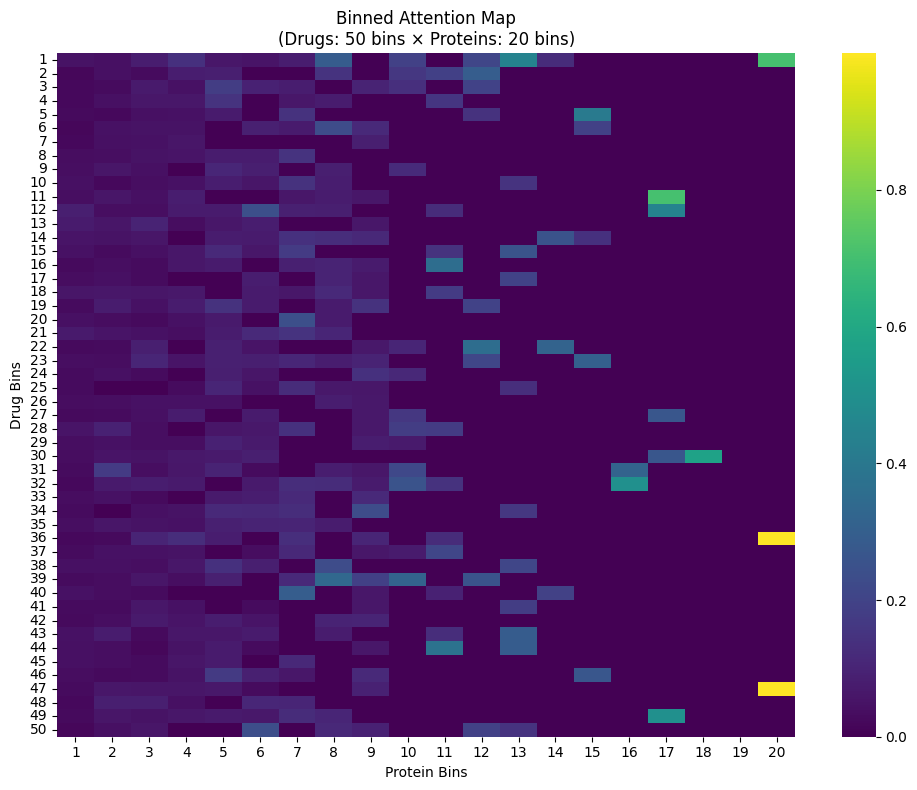

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_binned_attention_asymmetric(sampled_edges, sampled_attn_weights, num_drug_bins=50, num_protein_bins=20):
    # Get node ids
    drug_ids = sampled_edges[0].cpu().numpy()
    protein_ids = sampled_edges[1].cpu().numpy()
    attn = sampled_attn_weights  # [num_edges]

    # Normalize attention weights (min-max)
    attn = (attn - attn.min()) / (attn.max() - attn.min() + 1e-8)

    # Compute bin ranges independently
    drug_bins = np.linspace(drug_ids.min(), drug_ids.max() + 1, num_drug_bins + 1)
    protein_bins = np.linspace(protein_ids.min(), protein_ids.max() + 1, num_protein_bins + 1)

    # Digitize to get bin indices
    drug_bin_idx = np.digitize(drug_ids, drug_bins) - 1
    protein_bin_idx = np.digitize(protein_ids, protein_bins) - 1

    # Initialize attention matrix
    attn_matrix = np.zeros((num_drug_bins, num_protein_bins))
    counts = np.zeros((num_drug_bins, num_protein_bins)) + 1e-6  # Avoid division by zero

    # Accumulate attention scores into bins
    for i in range(len(attn)):
        d_bin = drug_bin_idx[i]
        p_bin = protein_bin_idx[i]
        attn_matrix[d_bin, p_bin] += attn[i]
        counts[d_bin, p_bin] += 1

    # Normalize: average attention per bin
    attn_matrix /= counts

    # Power transform for better visualization
    attn_matrix = np.power(attn_matrix, 0.5)  # Square root for better visibility

    # Set up the heatmap
    xticks = [str(i + 1) for i in range(num_protein_bins)]
    yticks = [str(i + 1) for i in range(num_drug_bins)]

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn_matrix, cmap="viridis", xticklabels=xticks, yticklabels=yticks)
    plt.title(f"Binned Attention Map\n(Drugs: {num_drug_bins} bins × Proteins: {num_protein_bins} bins)")
    plt.xlabel("Protein Bins")
    plt.ylabel("Drug Bins")
    plt.tight_layout()
    plt.show()

plot_binned_attention_asymmetric(sampled_edges, sampled_attn_weights, num_drug_bins=50, num_protein_bins=20)

# Get top k attention weighted edges

In [57]:
def get_top_k_attention_edges_with_ids(edge_index, attn_weights, drugs, targets, k=30):
    src = edge_index[0].detach().cpu().numpy()
    dst = edge_index[1].detach().cpu().numpy()
    attn = attn_weights.detach().cpu().numpy().squeeze()

    # Convert to DataFrame
    df = pd.DataFrame({
        'drug_id': src,
        'protein_id': dst,
        'attention_weight': attn
    })

    # Add readable IDs
    df['ChEMBL_ID'] = [drugs[i] for i in df['drug_id']]
    df['UniProt_ID'] = [targets[i] for i in df['protein_id']]

    # Reorder and sort
    df_sorted = df.sort_values(by='attention_weight', ascending=False).head(k)
    df_sorted = df_sorted[['ChEMBL_ID', 'UniProt_ID', 'attention_weight', 'drug_id', 'protein_id']]

    return df_sorted

In [58]:
edge_index, attn_weights = attn_scores[('drug', 'interacts', 'protein')]

top_edges_df = get_top_k_attention_edges_with_ids(
    edge_index=edge_index,
    attn_weights=attn_weights,
    drugs=drugs,  # list/array of ChEMBL IDs
    targets=targets,  # list/array of UniProt IDs
    k=30
)

print(top_edges_df.to_string(index=False))

    ChEMBL_ID UniProt_ID  attention_weight  drug_id  protein_id
 CHEMBL275938     P35520               1.0       34          33
CHEMBL4779479     Q9BQI3               1.0     6389         714
CHEMBL4758112     P49354               1.0    29951         876
CHEMBL5089882     P09601               1.0    30263         878
CHEMBL5291170     P16410               1.0    17481         827
CHEMBL4873384     Q13443               1.0    30140         877
CHEMBL4303622     Q13107               1.0    43033         924
CHEMBL2398336     P04792               1.0    13282         797
    CHEMBL165     P16083               1.0      129         801
  CHEMBL26512     P48067               1.0    29708         875
CHEMBL5202613     P24386               1.0    42951         922
CHEMBL1162107     O75581               1.0    42958         923
CHEMBL4747359     P04181               1.0     4123         659
CHEMBL4093222     P15289               1.0    33107         885
CHEMBL4798829     O75306               1

# Get a reconstructed subgraph around a protein

In [50]:
uniprot_id = 'P08253'
protein_name = "Matrix metalloproteinase-2"

# Map uniprot_id to index
protein_idx = target_map[uniprot_id]

# Create a new HeteroData object for the subgraph
subgraph_data = HeteroData()
subgraph_data['drug'].x = data['drug'].x
subgraph_data['protein'].x = data['protein'].x

# Create edges from protein_idx to all drugs
drug_targets = torch.arange(len(drugs), dtype=torch.long)  # All drug indices
protein_to_drug_src = torch.full((len(drugs),), protein_idx, dtype=torch.long)
protein_to_drug_dst = drug_targets
protein_to_drug_edges = torch.stack([protein_to_drug_src, protein_to_drug_dst], dim=0)  # shape: [2, num_drugs]

# Create edges from protein_idx to all other proteins (exclude self-loop)
protein_targets = torch.arange(len(targets), dtype=torch.long)  # All protein indices
mask = protein_targets != protein_idx
protein_targets = protein_targets[mask]

protein_to_protein_src = torch.full((protein_targets.size(0),), protein_idx, dtype=torch.long)
protein_to_protein_dst = protein_targets
protein_to_protein_edges = torch.stack([protein_to_protein_src, protein_to_protein_dst], dim=0)  # shape: [2, num_proteins-1]

# Combine edges into the subgraph data
subgraph_data['protein', 'interacts', 'drug'].edge_index = protein_to_drug_edges
subgraph_data['protein', 'interacts', 'protein'].edge_index = protein_to_protein_edges

# Add reverse edges
drug_to_protein_edges = protein_to_drug_edges[[1, 0]]
subgraph_data['drug', 'interacts', 'protein'].edge_index = drug_to_protein_edges

other_protein_edges = protein_to_protein_edges[[1, 0]]
subgraph_data['protein', 'interacts', 'protein'].edge_index = torch.cat([
    subgraph_data['protein', 'interacts', 'protein'].edge_index,
    other_protein_edges
], dim=1)

# Fit encoder on the original data
z_dict, _, _, _ = model.encode(data.x_dict, data.edge_index_dict)

# Pass the subgraph data to the decoder
pred_drug =  model.decode(z_dict, subgraph_data['protein', 'interacts', 'drug'].edge_index, 'protein', 'drug')
pred_drug = pred_drug.cpu().detach().numpy()
print(pred_drug.shape)

src_protein, dst_drug = data['protein', 'interacts', 'drug'].edge_index
connected_drugs = dst_drug[(src_protein == protein_idx)].tolist()

src_protein_2, dst_protein = data['protein', 'interacts', 'protein'].edge_index
connected_proteins = dst_protein[(src_protein_2 == protein_idx)].tolist()

# Get the top k predicted drugs for the given protein
top_k = 5
top_k_indices = np.argsort(pred_drug)[-top_k:][::-1]  # Get indices of top k predictions
drug_order = subgraph_data['protein', 'interacts', 'drug'].edge_index[1].cpu().numpy().copy()
top_k_indices = drug_order[top_k_indices]  # Get drug indices from the subgraph
top_k_drugs = [drugs[i] for i in top_k_indices]
top_k_scores = pred_drug[top_k_indices]
print(f"Top {top_k} predicted drugs for protein {uniprot_id}:")
for drug, score in zip(top_k_drugs, top_k_scores):
    print(f"Drug: {drug}, Score: {score:.4f}")
    # Check if the protein-drug interaction edge exists in the original data
    drug_idx = compound_map[drug]
    if drug_idx in connected_drugs:
        print(f"Interaction exists in the original data: {drug} - {uniprot_id}")

pred_protein = model.decode(z_dict, subgraph_data['protein', 'interacts', 'protein'].edge_index, 'protein', 'protein')
pred_protein = pred_protein.cpu().detach().numpy()

# Halve the predictions
pred_protein = pred_protein[:len(pred_protein)//2]
print(pred_protein.shape)

# Get the top k predicted proteins for the given protein
top_k = 5
top_k_indices = np.argsort(pred_protein)[-top_k:][::-1]  # Get indices of top k predictions
protein_order = subgraph_data['protein', 'interacts', 'protein'].edge_index[1].cpu().numpy().copy()
top_k_indices = protein_order[top_k_indices]  # Get protein indices from the subgraph
top_k_proteins = [targets[i] for i in top_k_indices]
top_k_scores = pred_protein[top_k_indices]
print(f"Top {top_k} predicted proteins for protein {uniprot_id}:")
for protein, score in zip(top_k_proteins, top_k_scores):
    print(f"Protein: {protein}, Score: {score:.4f}")
    # Check if the protein-protein interaction edge exists in the original data
    protein_idx_2 = target_map[protein]
    if protein_idx_2 in connected_proteins:
        print(f"Interaction exists in the original data: {uniprot_id} - {protein}")


(46660,)
Top 5 predicted drugs for protein P08253:
Drug: CHEMBL4855730, Score: 0.9914
Drug: CHEMBL4868141, Score: 0.9840
Drug: CHEMBL4855542, Score: 0.9834
Drug: CHEMBL4859660, Score: 0.9829
Drug: CHEMBL428647, Score: 0.9764
(4682,)
Top 5 predicted proteins for protein P08253:
Protein: Q07817, Score: 0.9334
Protein: P42336, Score: 0.9911
Protein: P04626, Score: 0.9703
Protein: O96013, Score: 0.9252
Protein: P24864, Score: 0.9796


In [51]:
# Get new edges from the model which are not in the original data

new_drugs = []
new_proteins = []

threshold_drug = 0.9
threshold_protein = 0.9

print("Protein being evaluated:", uniprot_id)

# Drug-Protein Edges
for idx, edge in enumerate(pred_drug):
    if edge > threshold_drug and drug_order[idx] not in connected_drugs:
        new_drugs.append((drugs[drug_order[idx]], edge))

# Protein-Protein Edges
for idx, edge in enumerate(pred_protein):
    if edge > threshold_protein and protein_order[idx] not in connected_proteins:
        new_proteins.append((targets[protein_order[idx]], edge))

# Print top k new drugs and proteins
print(f"Top new drugs with threshold as {threshold_drug} :")
for drug, score in sorted(new_drugs, key=lambda x: x[1], reverse=True):
    print(f"Drug: {drug}, Score: {score:.4f}")

print(f"Top new proteins with threshold as {threshold_protein} :")
for protein, score in sorted(new_proteins, key=lambda x: x[1], reverse=True):
    print(f"Protein: {protein}, Score: {score:.4f}")

Protein being evaluated: P08253
Top new drugs with threshold as 0.9 :
Drug: CHEMBL4855730, Score: 0.9914
Drug: CHEMBL4868141, Score: 0.9840
Drug: CHEMBL4855542, Score: 0.9834
Drug: CHEMBL4859660, Score: 0.9829
Drug: CHEMBL428647, Score: 0.9764
Drug: CHEMBL5267314, Score: 0.9757
Drug: CHEMBL4867931, Score: 0.9756
Drug: CHEMBL4522930, Score: 0.9746
Drug: CHEMBL4872258, Score: 0.9743
Drug: CHEMBL4867844, Score: 0.9735
Drug: CHEMBL4754873, Score: 0.9722
Drug: CHEMBL388978, Score: 0.9715
Drug: CHEMBL5090046, Score: 0.9714
Drug: CHEMBL4102324, Score: 0.9712
Drug: CHEMBL4859597, Score: 0.9709
Drug: CHEMBL5193039, Score: 0.9708
Drug: CHEMBL5270786, Score: 0.9706
Drug: CHEMBL941, Score: 0.9706
Drug: CHEMBL1490787, Score: 0.9703
Drug: CHEMBL5287694, Score: 0.9700
Drug: CHEMBL1989043, Score: 0.9699
Drug: CHEMBL5270740, Score: 0.9693
Drug: CHEMBL4758564, Score: 0.9689
Drug: CHEMBL364713, Score: 0.9688
Drug: CHEMBL4780986, Score: 0.9687
Drug: CHEMBL4739883, Score: 0.9681
Drug: CHEMBL4861353, Score:

In [90]:
print(len(new_drugs), len(new_proteins))

5 11


In [63]:
print(len(connected_drugs), len(connected_proteins))

206 6


# Visualising

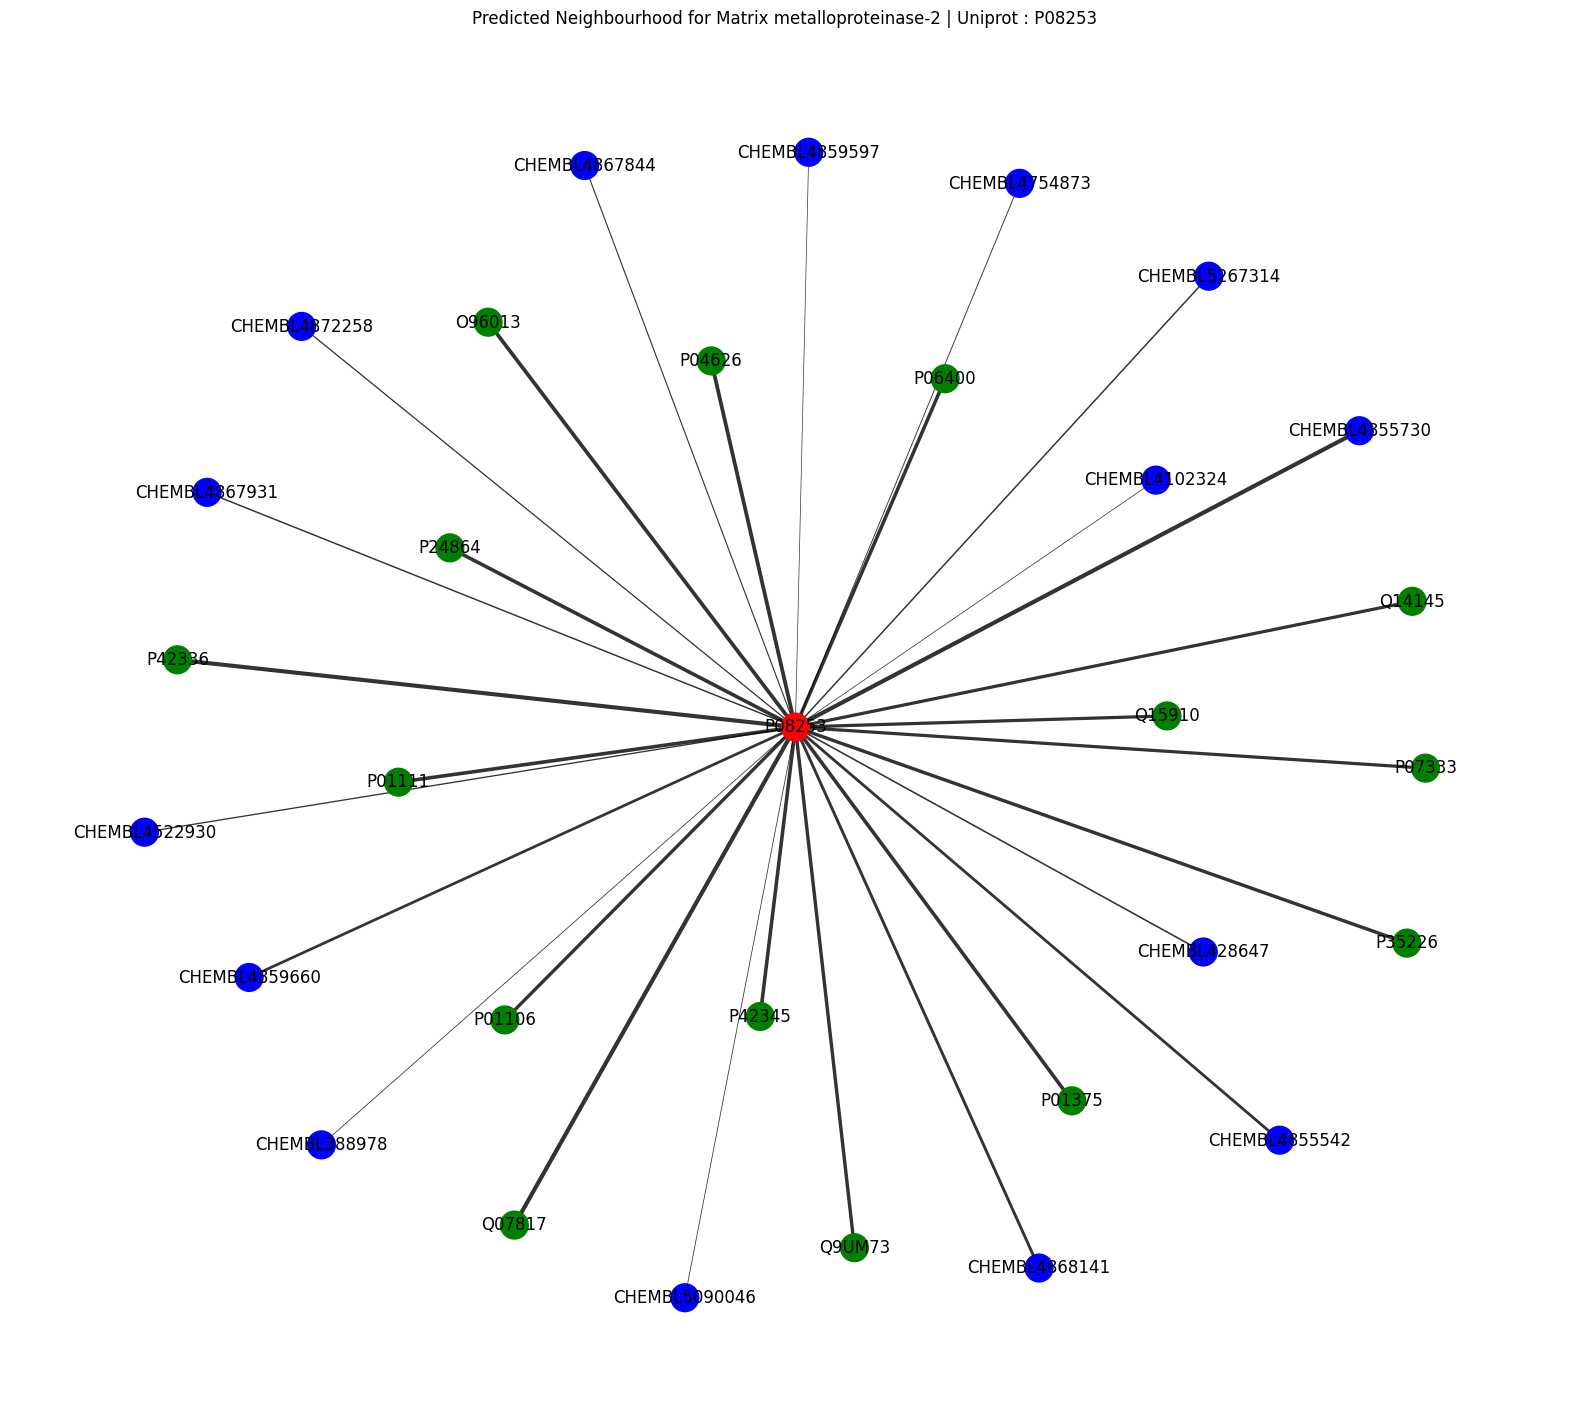

In [52]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# Add the main protein node
G.add_node(uniprot_id, label='protein', color='red')

top_k = 15

# Add drug nodes and connect them to the protein
for drug_id, score in sorted(new_drugs, key=lambda x: x[1], reverse=True)[:top_k]:  # Assume list of tuples (drug_id, score)
    G.add_node(drug_id, label='drug', color='blue')
    G.add_edge(uniprot_id, drug_id, weight=score)

# Add protein nodes and connect them to the protein
for protein_id, score in sorted(new_proteins, key=lambda x: x[1], reverse=True)[:top_k]:  # Assume list of tuples (protein_id, score)
    G.add_node(protein_id, label='protein', color='green')
    G.add_edge(uniprot_id, protein_id, weight=score)

# Get colors for nodes
colors = [G.nodes[n]['color'] for n in G.nodes]

# Get edge weights
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
edge_weights = np.array(edge_weights)

# Min-max scale between [0.5, 3] for better visibility
edge_weights_scaled = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min() + 1e-8)
edge_widths = 0.5 + edge_weights_scaled * (3 - 0.5)  # Scaled to range [0.5, 3]

# Draw the graph
plt.figure(figsize=(20,18))
pos = nx.spring_layout(G, seed=4, k=1)  # Layout for better visualization
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=400)
nx.draw_networkx_edges(G, pos, alpha=0.8, width=edge_widths)
nx.draw_networkx_labels(G, pos, font_size=12)

plt.title(f'Predicted Neighbourhood for {protein_name} | Uniprot : {uniprot_id}')
plt.axis('off')
plt.show()


# 3 Hop neighbourhood

In [53]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch_geometric.data import HeteroData

# Initialize
protein_name = "Matrix metalloproteinase-2"
uniprot_id = 'P08253'
protein_idx = target_map[uniprot_id]

# Fit encoder on full graph
z_dict, _, _, _ = model.encode(data.x_dict, data.edge_index_dict)

# Build the starting subgraph
subgraph_data = HeteroData()
subgraph_data['drug'].x = data['drug'].x
subgraph_data['protein'].x = data['protein'].x

# Prepare graph
G = nx.Graph()
protein_to_label = {}
drug_to_label = {}
node_label_map = {}
protein_count = 0
drug_count = 0

# Add starting protein
queue = [(protein_idx, f'P{protein_count}', 0)]  # (protein_idx, graph_node_id, hop)
protein_to_label[uniprot_id] = f'P{protein_count}'
G.add_node(protein_to_label[uniprot_id], label='protein', color='red')
protein_count += 1

# Begin BFS for 3 hops
max_hop = 3
top_k = 20

while queue:
    current_protein_idx, current_node_id, hop = queue.pop(0)
    if hop == max_hop:
        continue

    print(f"Processing node {current_node_id} at hop {hop}")

    # Prepare subgraph for this protein
    subgraph = HeteroData()
    subgraph['drug'].x = data['drug'].x
    subgraph['protein'].x = data['protein'].x

    drug_targets = torch.arange(len(drugs), dtype=torch.long)
    protein_targets = torch.arange(len(targets), dtype=torch.long)
    mask = protein_targets != current_protein_idx
    protein_targets = protein_targets[mask]

    protein_to_drug_edges = torch.stack([
        torch.full((len(drug_targets),), current_protein_idx, dtype=torch.long),
        drug_targets
    ], dim=0)

    protein_to_protein_edges = torch.stack([
        torch.full((len(protein_targets),), current_protein_idx, dtype=torch.long),
        protein_targets
    ], dim=0)

    subgraph['protein', 'interacts', 'drug'].edge_index = protein_to_drug_edges
    subgraph['protein', 'interacts', 'protein'].edge_index = protein_to_protein_edges
    subgraph['drug', 'interacts', 'protein'].edge_index = protein_to_drug_edges[[1, 0]]
    subgraph['protein', 'interacts', 'protein'].edge_index = torch.cat([
        protein_to_protein_edges,
        protein_to_protein_edges[[1, 0]]
    ], dim=1)

    # Predict
    pred_drug = model.decode(z_dict, subgraph['protein', 'interacts', 'drug'].edge_index, 'protein', 'drug')
    pred_drug = pred_drug.cpu().detach().numpy()

    pred_protein = model.decode(z_dict, subgraph['protein', 'interacts', 'protein'].edge_index, 'protein', 'protein')
    pred_protein = pred_protein.cpu().detach().numpy()
    pred_protein = pred_protein[:len(pred_protein)//2]

    # Get ordering
    drug_order = subgraph['protein', 'interacts', 'drug'].edge_index[1].cpu().numpy()
    protein_order = subgraph['protein', 'interacts', 'protein'].edge_index[1].cpu().numpy()

    # Get top drugs
    top_drug_indices = np.argsort(pred_drug)[-top_k:][::-1]
    for idx in top_drug_indices:
        drug_idx = drug_order[idx]
        drug_id = drugs[drug_idx]
        if drug_id not in drug_to_label:
            drug_to_label[drug_id] = f'D{drug_count}'
            G.add_node(drug_to_label[drug_id], label='drug', color='blue')
            drug_count += 1
        next_node_name = drug_to_label[drug_id]
        node_label_map[next_node_name] = drug_id
        G.add_edge(current_node_id, next_node_name, weight=pred_drug[idx])

    # Get top proteins
    top_protein_indices = np.argsort(pred_protein)[-top_k:][::-1]
    for idx in top_protein_indices:
        next_protein_idx = protein_order[idx]
        next_protein_id = targets[next_protein_idx]
        if next_protein_id not in protein_to_label:
            protein_to_label[next_protein_id] = f'P{protein_count}'
            G.add_node(protein_to_label[next_protein_id], label='protein', color='green')
            queue.append((next_protein_idx, protein_to_label[next_protein_id], hop+1))
            protein_count += 1
        next_node_name = protein_to_label[next_protein_id]
        node_label_map[next_node_name] = next_protein_id
        G.add_edge(current_node_id, next_node_name, weight=pred_protein[idx])

Processing node P0 at hop 0
Processing node P1 at hop 1
Processing node P2 at hop 1
Processing node P3 at hop 1
Processing node P4 at hop 1
Processing node P5 at hop 1
Processing node P6 at hop 1
Processing node P7 at hop 1
Processing node P8 at hop 1
Processing node P9 at hop 1
Processing node P10 at hop 1
Processing node P11 at hop 1
Processing node P12 at hop 1
Processing node P13 at hop 1
Processing node P14 at hop 1
Processing node P15 at hop 1
Processing node P16 at hop 1
Processing node P17 at hop 1
Processing node P18 at hop 1
Processing node P19 at hop 1
Processing node P20 at hop 1
Processing node P21 at hop 2
Processing node P22 at hop 2


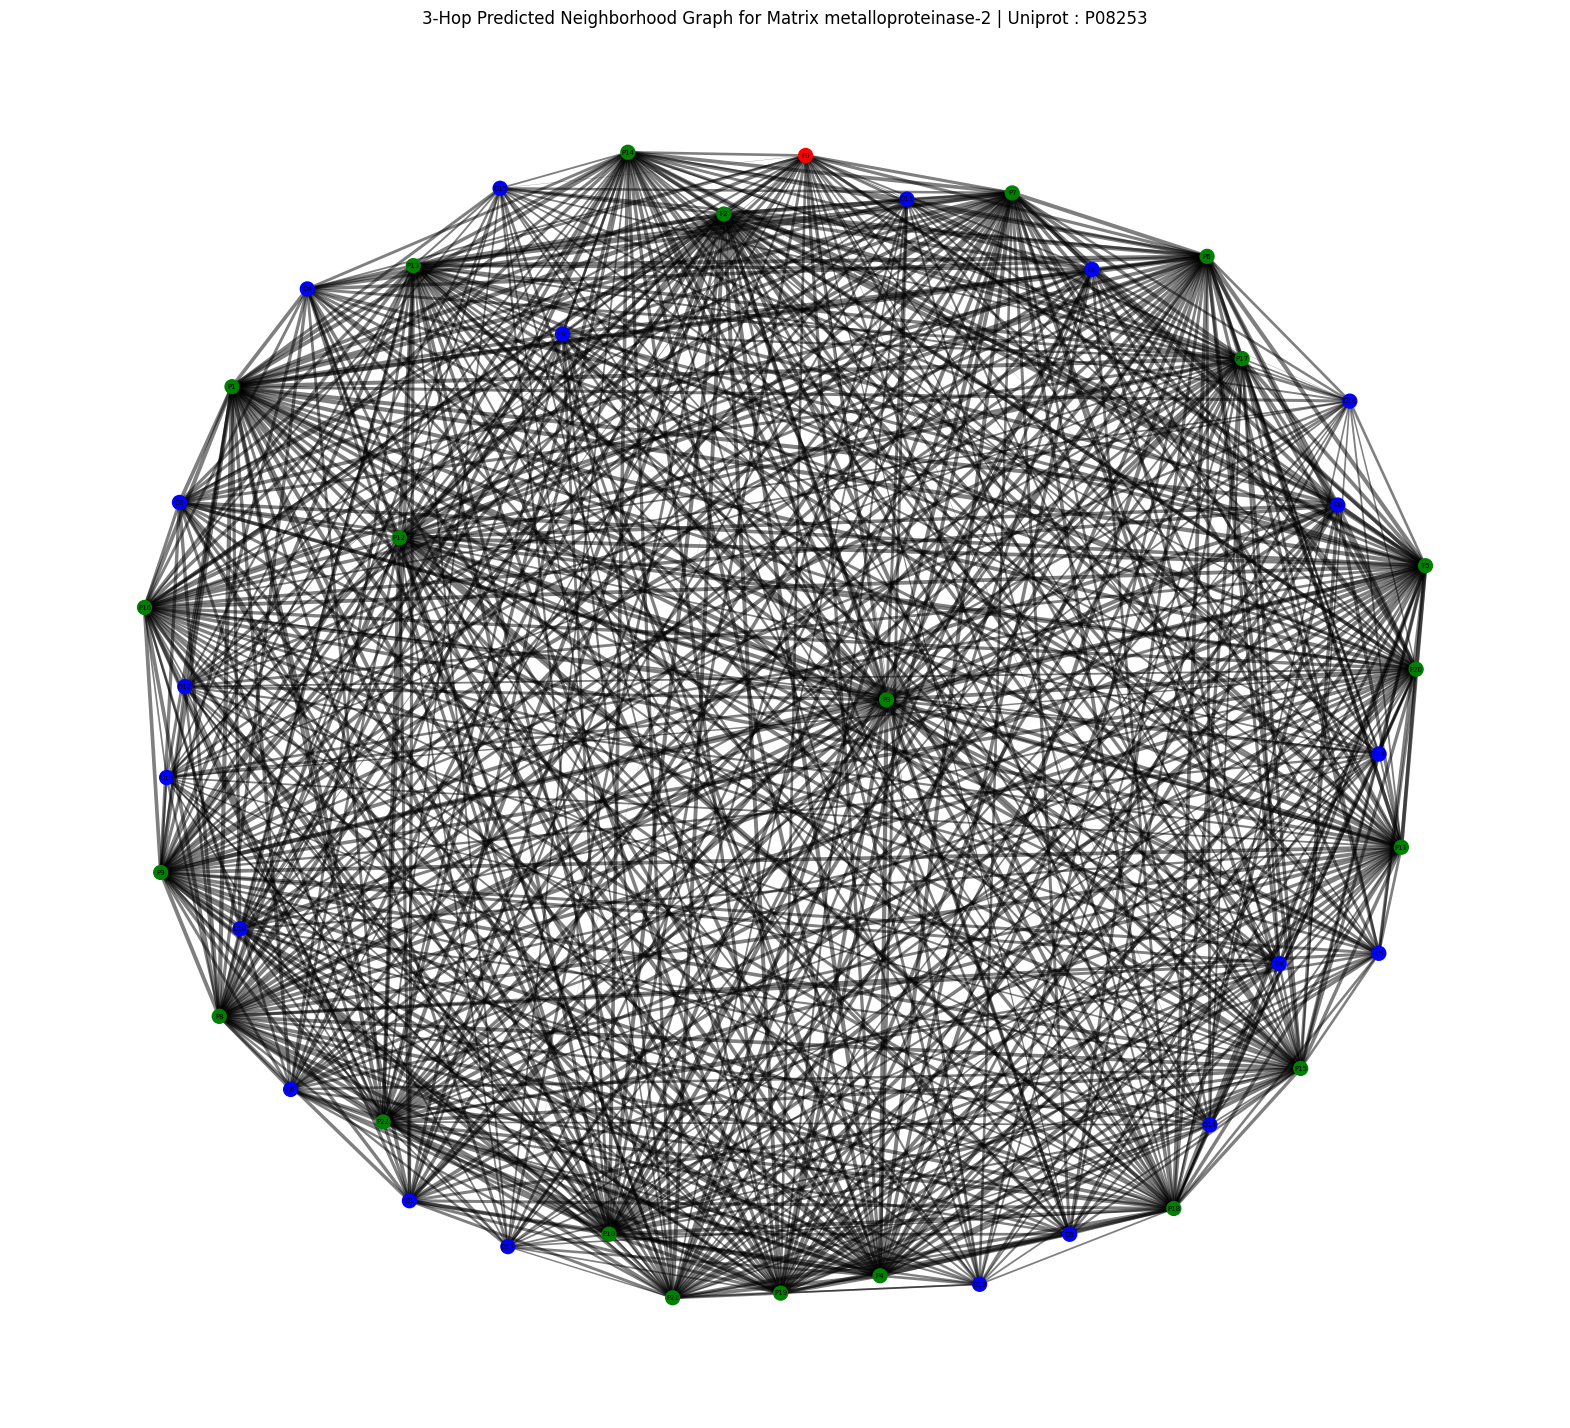


Legend:
D0 -> CHEMBL4855730
D1 -> CHEMBL4868141
D2 -> CHEMBL5190485
D3 -> CHEMBL4855979
D4 -> CHEMBL4781866
D5 -> CHEMBL1421
D6 -> CHEMBL2348350
D7 -> CHEMBL1782692
D8 -> CHEMBL4867931
D9 -> CHEMBL4855209
D10 -> CHEMBL4860979
D11 -> CHEMBL388978
D12 -> CHEMBL5193039
D13 -> CHEMBL4522930
D14 -> CHEMBL4739883
D15 -> CHEMBL4872258
D16 -> CHEMBL5172863
D17 -> CHEMBL5171825
D18 -> CHEMBL4859179
D19 -> CHEMBL4872322
P1 -> O96013
P2 -> P31749
P3 -> P22607
P4 -> Q86U44
P5 -> O60885
P6 -> P35226
P7 -> Q9NZQ7
P8 -> P01106
P9 -> Q15910
P10 -> P00533
P11 -> P07333
P12 -> O14746
P13 -> P12931
P14 -> O00512
P15 -> P31751
P16 -> Q9UM73
P17 -> P24864
P18 -> P21802
P19 -> P23458
P20 -> O96017
P21 -> P05067
P22 -> Q07817


In [54]:
# Draw graph
colors = [G.nodes[n]['color'] for n in G.nodes]

# Get raw edge weights
raw_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])

# Min-Max Scale the weights to [0, 1]
min_w = raw_weights.min()
max_w = raw_weights.max()
if max_w - min_w == 0:
    scaled_weights = np.ones_like(raw_weights)  # Avoid division by zero if all weights are same
else:
    scaled_weights = (raw_weights - min_w) / (max_w - min_w)

# Now scale for visibility (say between 0.1 and 3 thickness for aesthetics)
weights = 0.1 + scaled_weights * 3

plt.figure(figsize=(20,18))
pos = nx.spring_layout(G, seed=42, k=5)
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=100)
nx.draw_networkx_edges(G, pos, width=weights ,alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=5)

plt.title(f'3-Hop Predicted Neighborhood Graph for {protein_name} | Uniprot : {uniprot_id}')
plt.axis('off')
plt.show()

# Print legend
print("\nLegend:")
for key, value in node_label_map.items():
    print(f"{key} -> {value}")

In [55]:
nx.cycle_basis(G)

[['D0', 'P1', 'P22'],
 ['D1', 'P1', 'P22'],
 ['D2', 'P1', 'P22'],
 ['D3', 'P1', 'P22'],
 ['D4', 'P1', 'P22'],
 ['D5', 'P1', 'P22'],
 ['D6', 'P1', 'P22'],
 ['D7', 'P1', 'P22'],
 ['D8', 'P1', 'P22'],
 ['D9', 'P1', 'P22'],
 ['D10', 'P1', 'P22'],
 ['D11', 'P1', 'P22'],
 ['D12', 'P1', 'P22'],
 ['D13', 'P1', 'P22'],
 ['D14', 'P1', 'P22'],
 ['D16', 'P1', 'P22'],
 ['D15', 'P1', 'P22'],
 ['D17', 'P1', 'P22'],
 ['D18', 'P1', 'P22'],
 ['D19', 'P1', 'P22'],
 ['P2', 'P1', 'P22'],
 ['P3', 'P1', 'P22'],
 ['P4', 'P1', 'P22'],
 ['P5', 'P1', 'P22'],
 ['P6', 'P1', 'P22'],
 ['P7', 'P1', 'P22'],
 ['P8', 'P1', 'P22'],
 ['P9', 'P1', 'P22'],
 ['P10', 'P1', 'P22'],
 ['P11', 'P1', 'P22'],
 ['P12', 'P1', 'P22'],
 ['P13', 'P1', 'P22'],
 ['P14', 'P1', 'P22'],
 ['P15', 'P1', 'P22'],
 ['P17', 'P1', 'P22'],
 ['P16', 'P1', 'P22'],
 ['P18', 'P1', 'P22'],
 ['P19', 'P1', 'P22'],
 ['P20', 'P1', 'P22'],
 ['D0', 'P21', 'P1'],
 ['D1', 'P21', 'P1'],
 ['D2', 'P21', 'P1'],
 ['D4', 'P21', 'P1'],
 ['D3', 'P21', 'P1'],
 ['D6', 'P2